In [1]:
import os
import tensorflow as tf
from tensorflow import  keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.environ["KERAS_BACKEND"] = "tensorflow"

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
y_train.shape

(60000,)

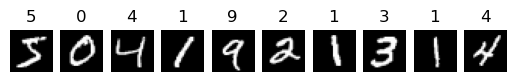

In [6]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')
plt.show()

In [7]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)

X_train Shape:  (60000, 784)
X_test Shape:  (10000, 784)


In [8]:
X_train = X_train/255
X_test = X_test/255

print("X_train: ", X_train.max(), X_train.min())
print("X_test: ", X_test.max(), X_test.min())

X_train:  1.0 0.0
X_test:  1.0 0.0


In [9]:
def create_mnist_pairs(X, y, num_pairs=100000):
    """
    Creates pairs of images from the MNIST dataset.
    
    Parameters:
        X (numpy array): Flattened MNIST images of shape (num_samples, 784).
        y (numpy array): Corresponding labels of shape (num_samples,).
        num_pairs (int): Number of pairs to generate.

    Returns:
        pairs (numpy array): Array of shape (num_pairs, 2, 784) containing image pairs.
        labels (numpy array): Array of shape (num_pairs,) containing 0 for same-class pairs and 1 for different-class pairs.
    """
    pairs = []
    labels = []
    num_classes = 10
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]  # Get indices for each class
    
    for _ in range(num_pairs // 2):  # Half same-class, half different-class pairs
        # Create a positive pair (same class)
        class_idx = np.random.randint(0, num_classes)
        i1, i2 = np.random.choice(digit_indices[class_idx], size=2, replace=False)
        pairs.append([X[i1], X[i2]])
        labels.append(0)
        
        # Create a negative pair (different classes)
        class_1, class_2 = np.random.choice(num_classes, size=2, replace=False)
        i1 = np.random.choice(digit_indices[class_1])
        i2 = np.random.choice(digit_indices[class_2])
        pairs.append([X[i1], X[i2]])
        labels.append(1)
    
    return np.array(pairs), np.array(labels)

In [10]:
def display_mnist_pairs(pairs, labels, num_samples=5):
    """
    Displays pairs of MNIST images in a horizontal line with their labels.

    Parameters:
        pairs (numpy array): Array of shape (num_pairs, 2, 784) containing image pairs.
        labels (numpy array): Array of shape (num_pairs,) containing 0 for same-class pairs and 1 for different-class pairs.
        num_samples (int): Number of pairs to display.
    """
    fig, axes = plt.subplots(1, num_samples * 2, figsize=(2 * num_samples, 2))
    
    for i in range(num_samples):
        img1, img2 = pairs[i]
        label = labels[i]

        # Reshape the images back to 28x28 for visualization
        img1 = img1.reshape(28, 28)
        img2 = img2.reshape(28, 28)

        # Display the first image
        axes[i * 2].imshow(img1, cmap='gray')
        axes[i * 2].axis('off')

        # Display the second image
        axes[i * 2 + 1].imshow(img2, cmap='gray')
        axes[i * 2 + 1].axis('off')

        # Set title above the second image
        axes[i * 2 + 1].set_title("Positive" if label == 0 else "Negative", fontsize=10)

    plt.tight_layout()
    plt.show()

In [11]:
X_train_pairs, y_train_pairs = create_mnist_pairs(X_train, y_train, num_pairs=120000)
X_test_pairs, y_test_pairs = create_mnist_pairs(X_test, y_test, num_pairs=20000)

In [12]:
X_train_pairs.shape, X_test_pairs.shape

((120000, 2, 784), (20000, 2, 784))

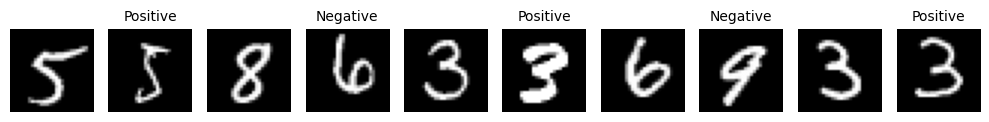

In [13]:
display_mnist_pairs(X_train_pairs, y_train_pairs, num_samples=5)

In [14]:
input1 = keras.Input(shape=(784,))
input2 = keras.Input(shape=(784,))

In [15]:
network = keras.models.Sequential([
    keras.Input((784,)),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation=None),
])

In [16]:
twin1 = network(input1)
twin2 = network(input2)

In [17]:
@tf.keras.utils.register_keras_serializable(name="euclidean_distance")
def euclidean_distance(twins):
    twin1_output, twin2_output = twins
    return keras.ops.norm(twin1_output - twin2_output, axis=1, keepdims=True)
distance = keras.layers.Lambda(euclidean_distance)([twin1, twin2])

In [18]:
model = keras.Model(inputs=[input1, input2], outputs=distance)

In [19]:
@tf.keras.utils.register_keras_serializable(name="contrastive_loss")
def contrastive_loss(y, d):
    margin = 1
    y = keras.ops.cast(y, d.dtype)
    return (1 - y) / 2 * keras.ops.square(d) + y / 2 * keras.ops.square(keras.ops.maximum(0.0, margin - d))

In [20]:
model.compile(loss=contrastive_loss, optimizer='adam', metrics=['binary_accuracy'])

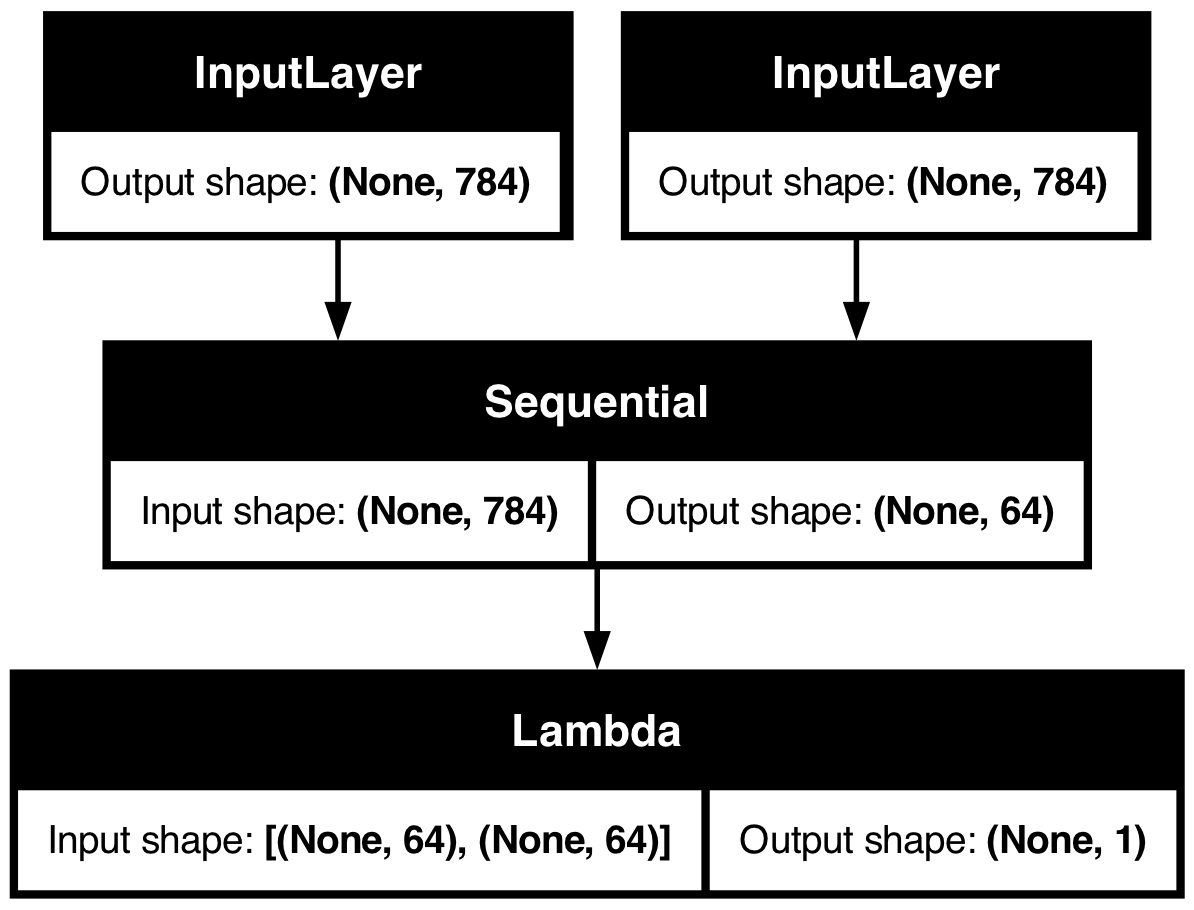

In [21]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, to_file='model.png')

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │    574,400 │ input_layer[0][0… │
│ (Sequential)        │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 574,400 (2.19 MB)

 Trainable params: 574,400 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(
    x=[X_train_pairs[:, 0], X_train_pairs[:, 1]],
    y=y_train_pairs[:], 
    batch_size=32, 
    epochs=10, 
    validation_split=0.1
    )

Epoch 1/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - binary_accuracy: 0.9065 - loss: 0.0407 - val_binary_accuracy: 0.9769 - val_loss: 0.0120
Epoch 2/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - binary_accuracy: 0.9799 - loss: 0.0105 - val_binary_accuracy: 0.9821 - val_loss: 0.0086
Epoch 3/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - binary_accuracy: 0.9879 - loss: 0.0062 - val_binary_accuracy: 0.9836 - val_loss: 0.0075
Epoch 4/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - binary_accuracy: 0.9913 - loss: 0.0046 - val_binary_accuracy: 0.9899 - val_loss: 0.0050
Epoch 5/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - binary_accuracy: 0.9938 - loss: 0.0032 - val_binary_accuracy: 0.9893 - val_loss: 0.0049
Epoch 6/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - binary_accuracy: 0.9948 - loss: 0.0027 - val_binary_accuracy: 0.9880 - val_loss: 0.0053
Epoch 7/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - binary_accuracy: 0.9954 - loss: 0.0023 - val_binary_accuracy: 0.9912 - val

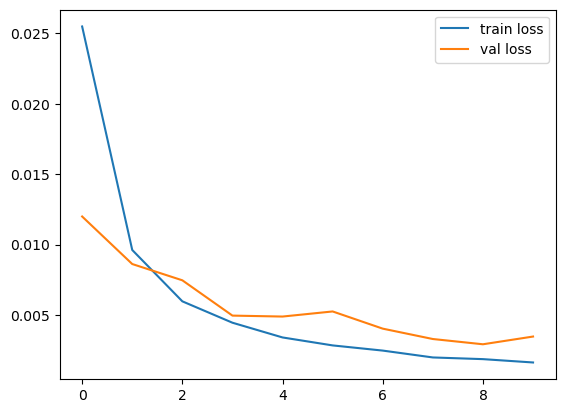

In [24]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [25]:
model.save(f"saved_model.keras")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step


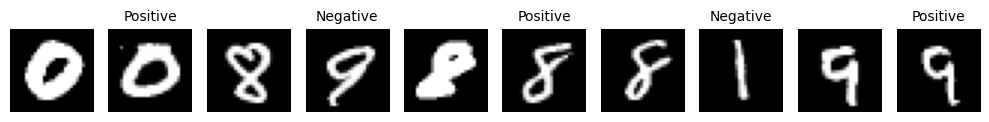

In [26]:
predictions = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]]) >= 0.5
display_mnist_pairs(X_test_pairs, predictions, num_samples=5)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import os
from PIL import Image

def save_mnist_images(num_images_per_class=10, output_dir='mnist_images'):
    """
    Download MNIST dataset and save sample images as PNG files
    
    Args:
        num_images_per_class: Number of images to save per digit (0-9)
        output_dir: Directory to save images (will be created if doesn't exist)
    """
    # Load MNIST data
    (train_images, train_labels), _ = mnist.load_data()
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Save sample images for each class
    for digit in range(10):
        print(f"Saving images for digit {digit}...")
        digit_indices = np.where(train_labels == digit)[0][:num_images_per_class]
        
        for i, idx in enumerate(digit_indices):
            img = train_images[idx]
            
            # Create PIL Image and save
            img_pil = Image.fromarray(img)
            filename = os.path.join(output_dir, f"{digit}_{i+1}.png")
            img_pil.save(filename)
    
    print(f"\nSaved {num_images_per_class*10} images to {output_dir}/")
    print("Directory structure:")
    print(f"{output_dir}/")
    print("├── 0_1.png")
    print("├── 0_2.png")
    print("├── ...")
    print("└── 9_{num_images_per_class}.png")

# Example usage:
save_mnist_images(num_images_per_class=20, output_dir='mnist_samples')

Saving images for digit 0...
Saving images for digit 1...
Saving images for digit 2...
Saving images for digit 3...
Saving images for digit 4...
Saving images for digit 5...
Saving images for digit 6...
Saving images for digit 7...
Saving images for digit 8...
Saving images for digit 9...

Saved 200 images to mnist_samples/
Directory structure:
mnist_samples/
├── 0_1.png
├── 0_2.png
├── ...
└── 9_{num_images_per_class}.png


In [28]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Sequential name=sequential, built=True>,
 <Lambda name=lambda, built=True>]

In [29]:
embedding_model = model.layers[2]
embedding_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,400 (2.19 MB)

 Trainable params: 574,400 (2.19 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
index1 = np.random.choice(np.where(y_test_pairs == 0)[0])
index2 = np.random.choice(np.where(y_test_pairs == 0)[0])
index3 = np.random.choice(np.where(y_test_pairs == 1)[0])

index1, index2, index3

(np.int64(7734), np.int64(19722), np.int64(14581))

In [31]:
embedding1 = embedding_model(X_test_pairs[index1, 0].reshape(1, -1)).numpy()
embedding2 = embedding_model(X_test_pairs[index1, 1].reshape(1, -1)).numpy()
embedding3 = embedding_model(X_test_pairs[index3, 0].reshape(1, -1)).numpy()

In [32]:
keras.ops.norm(embedding1 - embedding2).numpy(), keras.ops.norm(embedding1 - embedding3).numpy()

(np.float32(0.008044943), np.float32(1.0601665))

In [33]:
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA

# Get embeddings for ALL test pairs
def get_pair_embeddings(pairs):
    """Extract embeddings for both images in pairs"""
    emb1 = np.array([embedding_model(pair[0].reshape(1, -1)).numpy()[0] for pair in pairs])
    emb2 = np.array([embedding_model(pair[1].reshape(1, -1)).numpy()[0] for pair in pairs])
    return np.concatenate([emb1, emb2], axis=0)

# Get combined embeddings and labels
all_embeddings = get_pair_embeddings(X_test_pairs)
all_labels = np.concatenate([y_test_pairs, y_test_pairs])  # Duplicate labels for both embeddings

# Add individual test embeddings (optional)
test_embeddings = np.array([embedding_model(img.reshape(1, -1)).numpy()[0] for img in X_test])
all_embeddings = np.concatenate([all_embeddings, test_embeddings])
all_labels = np.concatenate([all_labels, y_test])

In [34]:
import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA

def plot_embeddings_3d(embeddings, labels, sample_size=1000):
    """
    Interactive 3D visualization of embeddings
    
    Parameters:
        embeddings (np.array): Array of embeddings (n_samples, embedding_dim)
        labels (np.array): Array of corresponding labels
        sample_size (int): Number of points to display (for performance)
    """
    # Random sampling for better performance
    idx = np.random.choice(len(embeddings), min(sample_size, len(embeddings)), replace=False)
    sample_emb = embeddings[idx]
    sample_labels = labels[idx]
    
    # Reduce to 3D with PCA
    pca = PCA(n_components=3)
    pca_results = pca.fit_transform(sample_emb)
    
    # Create the plot
    fig = go.Figure(data=[go.Scatter3d(
        x=pca_results[:, 0],
        y=pca_results[:, 1],
        z=pca_results[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=sample_labels,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title='Class')
        ),
        hovertemplate="<b>Class %{marker.color}</b><extra></extra>"
    )])
    
    # Formatting
    fig.update_layout(
        scene=dict(
            xaxis_title=f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
            yaxis_title=f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
            zaxis_title=f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)',
            camera=dict(eye=dict(x=1.5, y=1.5, z=0.5))
        ),
        margin=dict(l=0, r=0, b=0, t=30),
        height=600,
        title_text="3D Embedding Space"
    )
    
    fig.show()

# Example usage with MNIST
test_embeddings = embedding_model.predict(X_test.reshape(-1, 784))
plot_embeddings_3d(test_embeddings, y_test, sample_size=10000)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
